In [2]:
import re
from pathlib import Path
from collections import Counter
import math
import pandas as pd
import matplotlib.pyplot as plt

# --------- Paths (adjusted for repo layout) ----------
DATA_DIR = Path("../../data") if Path(".").name != "applied-NLP-project" else Path("data")
RESULTS_DIR = Path("../../results") if Path(".").name != "applied-NLP-project" else Path("results")
OUT_DIR = RESULTS_DIR / "color_words"
OUT_DIR.mkdir(parents=True, exist_ok=True)

BOOKS = {
    "War_and_Peace": DATA_DIR / "War_and_Peace.txt",
    "Anna_Karenina": DATA_DIR / "Anna_Karenina.txt",
}

# --------- Helpers: load and normalize ----------
def load_text(path: Path) -> str:
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    return path.read_text(encoding="utf-8", errors="ignore")


In [3]:
def normalize(text: str) -> str:
    # keep body only if Gutenberg markers present
    start = text.find('*** START')
    end   = text.find('*** END')
    if start != -1 and end != -1 and end > start:
        text = text[start:end]
    return text.replace('\r\n', '\n')


In [4]:
WORD_RE = re.compile(r"[A-Za-z']+")
def words(text: str):
    return WORD_RE.findall(text.lower())

def sentences(text: str):
    return [s.strip() for s in re.split(r'(?<=[.!?])\s+', text) if s.strip()]


In [5]:
# --------- Color list (expand if you want) ----------
COLOR_LIST = {
    'red','orange','yellow','green','blue','indigo','violet','purple','pink','brown',
    'black','white','gray','grey','scarlet','crimson','emerald','amber','gold','silver',
    'lavender','mauve','ivory','beige','teal','turquoise','magenta','maroon','navy'
}

# --------- Load & tokenize each book ----------
texts_raw = {}
texts = {}
tokens = {}
sents = {}

for name, p in BOOKS.items():
    raw = load_text(p)
    texts_raw[name] = raw
    txt = normalize(raw)
    texts[name] = txt
    tokens[name] = words(txt)
    sents[name] = sentences(txt)
    print(f"{name}: chars={len(txt):,} words={len(tokens[name]):,} sentences={len(sents[name]):,}")

# --------- Count color words ----------
def count_colors(token_list):
    c = Counter(w for w in token_list if w in COLOR_LIST)
    return c, sum(c.values()), len(token_list)

counts = {}
hits = {}
totals = {}
for name in BOOKS.keys():
    c, h, t = count_colors(tokens[name])
    counts[name] = c
    hits[name] = h
    totals[name] = t
    print(f"{name} top colors:", c.most_common(15), "| rate per 100k:", (h/t)*100000 if t else 0)


War_and_Peace: chars=3,208,340 words=583,377 sentences=27,141
Anna_Karenina: chars=1,964,818 words=358,381 sentences=17,074
War_and_Peace top colors: [('white', 199), ('red', 137), ('black', 133), ('blue', 94), ('gray', 86), ('green', 47), ('gold', 43), ('silver', 26), ('yellow', 20), ('purple', 15), ('pink', 13), ('crimson', 12), ('brown', 11), ('scarlet', 4), ('maroon', 3)] | rate per 100k: 145.18913155643776
Anna_Karenina top colors: [('white', 136), ('red', 85), ('black', 69), ('gray', 45), ('blue', 28), ('green', 27), ('yellow', 17), ('pink', 15), ('gold', 13), ('silver', 12), ('crimson', 11), ('brown', 7), ('ivory', 3), ('scarlet', 2), ('violet', 2)] | rate per 100k: 133.09857386412784


In [6]:
# --------- Rolling windows for "color bursts" ----------
def rolling_color_windows(tokens_list, window=800, step=200, color_list=COLOR_LIST):
    hits_per_window = []
    max_i = max(1, len(tokens_list) - window + 1)
    for i in range(0, max_i, step):
        chunk = tokens_list[i:i+window]
        c = sum(1 for w in chunk if w in color_list)
        hits_per_window.append((i, i+window, c, c * (100000/window)))  # per 100k
    return hits_per_window

def nearest_sentence_span(tokens_list, sents_list, start_idx, end_idx):
    head = " ".join(tokens_list[start_idx:start_idx+20])
    for k, s in enumerate(sents_list):
        if head[:50] in s:
            j0 = max(0, k-1); j1 = min(len(sents_list), k+3)
            return j0, j1, " ".join(sents_list[j0:j1])
    return None, None, " ".join(tokens_list[start_idx:end_idx])[:500]

# run rolling windows and print top bursts
for name in BOOKS.keys():
    roll = rolling_color_windows(tokens[name], window=800, step=200)
    top = sorted(roll, key=lambda x: x[3], reverse=True)[:5]
    print(f"\n=== {name} color bursts ===")
    for a,b,h,rate in top:
        j0,j1,preview = nearest_sentence_span(tokens[name], sents[name], a, b)
        print(f"[tokens {a}-{b}] hits={h} | {rate:.0f} per 100k")
        print(preview[:400], "…\n")



=== War_and_Peace color bursts ===
[tokens 234800-235600] hits=11 | 1375 per 100k
v took no further part in any business affairs but devoted himself with passionate enthusiasm to what was to him a new pursuit the chase for which his father kept a large establishment chapter iii the weather was already growing wintry and morning frosts congealed an earth saturated by autumn rains the verdure had thickened and its bright green stood out sharply against the brownish strips of wint …

[tokens 216200-217000] hits=10 | 1250 per 100k
spite of her age and plainness she had gone through the same process as the rost vs but with less flurry for to her it was a matter of routine her ugly old body was washed perfumed and powdered in just the same way she had washed behind her ears just as carefully and when she entered her drawing room in her yellow dress wearing her badge as maid of honor her old lady s maid was as full of rapturou …

[tokens 234600-235400] hits=10 | 1250 per 100k
had mismanaged 

Saved CSV: ../../results/color_words/color_counts_per10k.csv


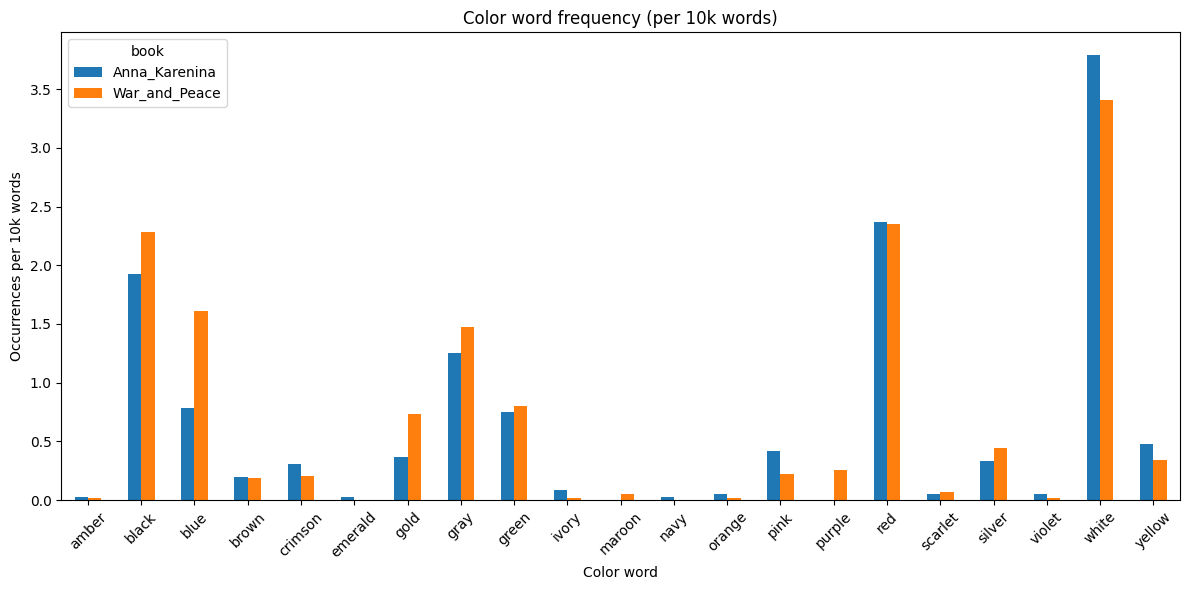

In [7]:
# --------- Save counts to CSV for later ------
rows = []
for name in BOOKS.keys():
    total = totals[name]
    for color, c in counts[name].items():
        rows.append({
            "book": name,
            "color": color,
            "count": c,
            "per_10k": c / total * 10000 if total else 0
        })

df_out = pd.DataFrame(rows)
df_out.to_csv(OUT_DIR / "color_counts_per10k.csv", index=False)
print("Saved CSV:", (OUT_DIR / "color_counts_per10k.csv").as_posix())

# --------- Simple plot (counts per 10k) ----------
plt.rcParams.update({'figure.max_open_warning': 0})

pivot = df_out.pivot_table(index="color", columns="book", values="per_10k", fill_value=0)
pivot = pivot.loc[sorted(pivot.index)]  # sort colors alphabetically
pivot.plot(kind="bar", figsize=(12,6))
plt.title("Color word frequency (per 10k words)")
plt.ylabel("Occurrences per 10k words")
plt.xlabel("Color word")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
